## 数据分析岗位需求分析
1. 数据来自2019-08-14拉勾网搜索关键词“数据分析”的职位列表，共爬取了依职位数量降序排列的前10个城市。
3. 由于拉勾一次只显示30页×15个职位，故对超过450个职位的城市，降序爬取数量超过50个职位的一级行政区。
4. 本文使用pandas进行数据处理和分析，结合seaborn和pyecharts包进行数据可视化。Python运行版本为3.6.7。

### 分析目标
* 由于近期致力于找一份数据分析相关的工作，故分析目标为市场对数据分析师的需求状况，以及筛选出适合尝试的公司和职位。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyecharts
plt.style.use('ggplot')
%matplotlib inline

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  #解决seaborn中文字体显示问题
plt.rc('figure', figsize=(6, 6))  #把plt默认的图片size调大一点
plt.rcParams['figure.dpi'] = 500 #分辨率调高一点

**********
## 1.数据的基本处理
* 导入数据，随机抽取5个数据样本观察是否正确
* 查看数据的行列数、数据类型、非空记录数，看看有没有重复数据，去重

In [4]:
data = pd.read_csv('lagou0814_total.csv', header=0,  encoding='gbk') #导入数据

In [5]:
data.sample(5)

,城市,区域,公司全名,公司简称,公司规模,融资阶段,职位名称,工资,工作经验,学历要求,职位福利,行业,发布时间
46,北京,朝阳区,深圳市中手游网络科技有限公司,CMGE中手游,500-2000人,上市公司,数据分析师,6k-12k,1-3年,本科,大平台 晋升机会 福利待遇好 团队氛围棒,"移动互联网,游戏",2019/8/14 11:12
963,上海,长宁区,上海麦图信息科技有限公司,麦图科技,15-50人,A轮,数据分析专员-人工智能方向,7k-9k,不限,大专,股票期权，带薪年假，弹性工作，扁平管理,数据服务,2019/8/7 13:50
182,北京,朝阳区,北京蚂蜂窝网络科技有限公司,马蜂窝,500-2000人,D轮及以上,呼叫中心-数据分析师（专家岗）,15k-30k,5-10年,不限,公司核心交易部门,旅游,2019/7/16 16:24
1538,杭州,拱墅区,微梦创科网络科技（中国）有限公司,新浪微博,2000人以上,上市公司,高级数据分析师,20k-40k,3-5年,不限,机器学习、核心业务,文娱丨内容,2019/8/14 15:08
1284,深圳,福田区,深圳依时货拉拉科技有限公司,货拉拉,2000人以上,C轮,资深数据分析师(J11772),50k-70k,5-10年,本科,发展空间大,"移动互联网,消费生活",2019/8/13 11:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 13 columns):
城市      1886 non-null object
区域      1885 non-null object
公司全名    1886 non-null object
公司简称    1886 non-null object
公司规模    1886 non-null object
融资阶段    1886 non-null object
职位名称    1886 non-null object
工资      1886 non-null object
工作经验    1886 non-null object
学历要求    1886 non-null object
职位福利    1886 non-null object
行业      1886 non-null object
发布时间    1886 non-null object
dtypes: object(13)
memory usage: 191.7+ KB


* 去除重复记录,drop_duplicates函数不会改变数据框的结构
* 就是说仍然有1886行，但是非空行变成了1879，并且空行会保持在原索引位置

In [7]:
data.drop_duplicates(inplace=True)
data.shape

(1879, 13)

#### 根据观察可知：
* 几乎没有缺失值，每个字段的内容也高度标准化
* 所有数据都被导入成了object类型
* 一共有13列，1886条记录，重复记录7条，这跟前面提到的爬取方式有关
* 可以看到来自拉勾的数据非常规整

**********
## 2.数据处理
根据基本信息，处理思路是：
* ‘工资’字段处理成数值类型，发布时间处理成date类型
* 然后处理字符型字段，把需要标准化为类别型的标准化为类别型


### 2.1数值型字段处理
只有‘工资’一个字段需要处理，取每个工资范围上下界的平均数，新建一个‘平均工资’字段存储，表示工资的值

In [8]:
data['工资'].sample(5)

318     20k-40k
219     20k-35k
797      8k-12k
1415    20k-40k
896     35k-65k
Name: 工资, dtype: object

* 一行提两个数然后取平均，理论上可以，但我一下没想到怎么做，试了几次都只能提取一个数，所以写了个函数

In [9]:
import re
def get_avg_salary(data):
    pat =  r"(.*)k-(.*)k"
    if 'k' in data:
        low,high = re.findall(pattern=pat,string=data)[0]
        return (float(low)+float(high))/2

data['平均工资'] = data['工资'].apply(get_avg_salary)

In [10]:
data['工资'].head()

0    15k-20k
1    20k-40k
2    20k-40k
3    15k-25k
4    15k-25k
Name: 工资, dtype: object

In [11]:
data['平均工资'].head()

0    17.5
1    30.0
2    30.0
3    20.0
4    20.0
Name: 平均工资, dtype: float64

In [15]:
data['平均工资'] = (data['平均工资']*1000).round(2)

* 乘个1000，标准化为以(/元)为单位

In [16]:
data['平均工资'].head()

0    17500.0
1    30000.0
2    30000.0
3    20000.0
4    20000.0
Name: 平均工资, dtype: float64

In [17]:
data['平均工资'].mean().round(2)

19824.36

* 看看工资的总平均数，这接近两万的数目感觉有点虚高，
* 我在一些网站看到的统计数据只有一万出头，
* 前面的抽样我们也看到了，很多职位给的薪酬范围很大，20k-40k这种形式的很多
* 所以我认为用给出薪酬范围的下界作为薪资的数值更有代表性
* 那就新建一个‘工资下界’字段，后面的分析用这个字段展开

In [45]:
data['工资下界'] = data['工资'].str.extract('([0-9.]+)k-([0-9.]+)k')
data['工资下界'] = data['工资下界'].astype('float')*1000

extract()这个方法只返回匹配的第一个子串

In [46]:
data['工资下界'].head()

0    15000.0
1    20000.0
2    20000.0
3    15000.0
4    15000.0
Name: 工资下界, dtype: float64

* 这个数看起来自然一点

In [112]:
data['工资下界'].mean().round(2)

14520.79

### 2.2时间字段处理
* 只有‘发布时间’这一个字段需要处理

In [47]:
data['发布时间'].sample(5)

1762    2019/8/13 16:00
1549    2019/8/14 14:51
1742    2019/8/14 14:15
758     2019/8/14 17:28
410     2019/8/14 13:31
Name: 发布时间, dtype: object

* 我只想要前面的日期
* str.extract返回第一个匹配的子串

In [49]:
data['发布时间'] = data['发布时间'].str.extract('(.*) (.*)', expand=True)
data['发布时间'].sample(5)

611     2019/8/13
79      2019/8/14
1313    2019/8/14
816     2019/8/14
1058    2019/7/27
Name: 发布时间, dtype: object

* 转换为datetime日期格式

In [172]:
data['发布时间'] = pd.to_datetime(data['发布时间'])#format='%Y/%m/%d'

In [173]:
data['发布时间'].sample(5)

1430   2019-08-14
1122   2019-08-13
963    2019-08-07
1209   2019-08-14
1625   2019-07-25
Name: 发布时间, dtype: datetime64[ns]

### 2.3字符型字段处理
* 看看‘公司规模’、‘学历要求’等需要为类别型的字段是否干净

In [50]:
data['公司规模'].unique()

array(['150-500人', '50-150人', '2000人以上', '500-2000人', '15-50人', '少于15人'],
      dtype=object)

In [51]:
data['融资阶段'].unique()

array(['B轮', 'C轮', '不需要融资', 'D轮及以上', 'A轮', '未融资', '上市公司', '天使轮'],
      dtype=object)

In [52]:
data['工作经验'].unique()

array(['1-3年', '3-5年', '5-10年', '应届毕业生', '不限', '1年以下', '10年以上'],
      dtype=object)

In [53]:
data['学历要求'].unique()

array(['本科', '不限', '大专', '硕士', '博士'], dtype=object)

* 全都很干净，不需要处理
* 至于城市，关于开始说的爬取方式，只有10个城市

In [38]:
data['城市'].unique()

array(['北京', '上海', '深圳', '杭州', '广州', '成都', '南京', '武汉', '厦门', '长沙'],
      dtype=object)

* 把处理后的数据用一个新的csv文件，保存到本地

In [55]:
data.to_csv('lagou_clean.csv',index=False, encoding='utf-8-sig')

**********
## 3.数据分析
利用以上的城市、薪资、学历、公司等相关字段，仅基于拉勾的数据分析目前市场对数据分析师的需求情况

### 3.1 清洗完的数据的基本情况

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1879 entries, 0 to 1885
Data columns (total 15 columns):
城市      1879 non-null object
区域      1878 non-null object
公司全名    1879 non-null object
公司简称    1879 non-null object
公司规模    1879 non-null object
融资阶段    1879 non-null object
职位名称    1879 non-null object
工资      1879 non-null object
工作经验    1879 non-null object
学历要求    1879 non-null object
职位福利    1879 non-null object
行业      1879 non-null object
发布时间    1879 non-null object
平均工资    1876 non-null float64
工资下界    1876 non-null float64
dtypes: float64(2), object(13)
memory usage: 234.9+ KB


* 此次分析跟 ‘区域’ 和 ‘职位福利’ 两个字段没有太大关系，就先去掉这两个字段,前面已经保存了，可以放心删

In [65]:
data.drop(['区域','职位福利'],axis=1,inplace=True)

In [67]:
data.shape

(1879, 13)

In [66]:
data.sample(5)

,城市,公司全名,公司简称,公司规模,融资阶段,职位名称,工资,工作经验,学历要求,行业,发布时间,平均工资,工资下界
1717,广州,广州尚智思德教育科技有限公司,尚德机构,2000人以上,不需要融资,数据分析师,7k-10k,不限,本科,教育,2019/7/15,8500.0,7000.0
1509,杭州,浙江胄天科技股份有限公司,胄天科技,50-150人,B轮,数据分析师,10k-20k,3-5年,本科,"信息安全,数据服务",2019/8/14,15000.0,10000.0
463,北京,北京小米科技有限责任公司,小米,2000人以上,D轮及以上,小米金融-数据分析（建模岗）,15k-30k,3-5年,本科,硬件,2019/7/25,22500.0,15000.0
793,上海,鑫涌算力信息科技（上海）有限公司,信用算力,150-500人,B轮,数据分析师,15k-30k,1-3年,本科,"移动互联网,金融",2019/8/14,22500.0,15000.0
631,北京,北京字节跳动科技有限公司,字节跳动,2000人以上,C轮,平台数据分析,10k-20k,1-3年,本科,文娱丨内容,2019/8/13,15000.0,10000.0


### 3.2城市
#### 3.2.1城市与职位数量
* 北上广深杭这五个城市毫无疑问地占据了前五的位置，其中北京遥遥领先，有740个职位，占39.38%；上海有398个，占21.18%；北上广深杭这五个城市占了所有的92.33%，说明这个职位还是集中在一线城市
* 另外值得注意的是，深圳排到了第三，在广州和杭州的前面，而且高出的比例不低
* 原以为杭州的职位都被阿里系霸占了，结果抽取数据出来一看发现并没有，甚至连阿里的影子都没有看见，其中原因值得再挖一下

In [68]:
city = data['城市'].value_counts()
city

北京    740
上海    398
深圳    286
广州    175
杭州    136
成都     44
武汉     43
南京     28
厦门     17
长沙     12
Name: 城市, dtype: int64

In [71]:
city_pct = (city/city.sum()).map(lambda x: '{:,.2%}'.format(x))
city_pct

北京    39.38%
上海    21.18%
深圳    15.22%
广州     9.31%
杭州     7.24%
成都     2.34%
武汉     2.29%
南京     1.49%
厦门     0.90%
长沙     0.64%
Name: 城市, dtype: object

In [62]:
(city/city.sum())[:5].sum()

0.9233634912187334

* 如果把数据爬全，前5个城市的职位数量占总体的比例应该会比目前这个数低几个百分点，但是影响也不会很大

* 接下来画图
#### 关于画图的说明(后面的图也一样)：
* pyecharts包画的图都存成html文件，另作它用，因为这些图上传github以后也不能看
* 每次我会用matplotlib包画个简易的图放这里面用来看

In [72]:
bar = pyecharts.Bar('城市与职位数量')
bar.add(name="", x_axis=city.index, y_axis=city, xaxis_label_textsize=15,
        yaxis_label_textsize=20, is_label_show=True)
bar.render('城市与职位数量.html')

* matplotlib这个包，没有一个方便的生成颜色的方法，比如R就有rainbow()方法，返回指定数量的彩色
* 就写了一个伪随机取色的函数，在自动的画图只有一个颜色的情况使用

In [105]:
import random
# 伪随机生成颜色
def randomcolor(ncolor):
    colorArr = ['#9D2932', '#3E565A', '#C3272B', '#494166', '#C32136', '#A88460', '#177CB0', '#74868A', '#424B50', '#B36D61', '#C3272B', '#A1AFC9', '#FF3300', '#ED5736', '#76664D','#A3E2C5','#415065','#9D2932','#F0EDDC','#549786','#CCA4E3','#484163','#AFA4E0']
    colors = random.sample(colorArr, ncolor)
    return colors

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

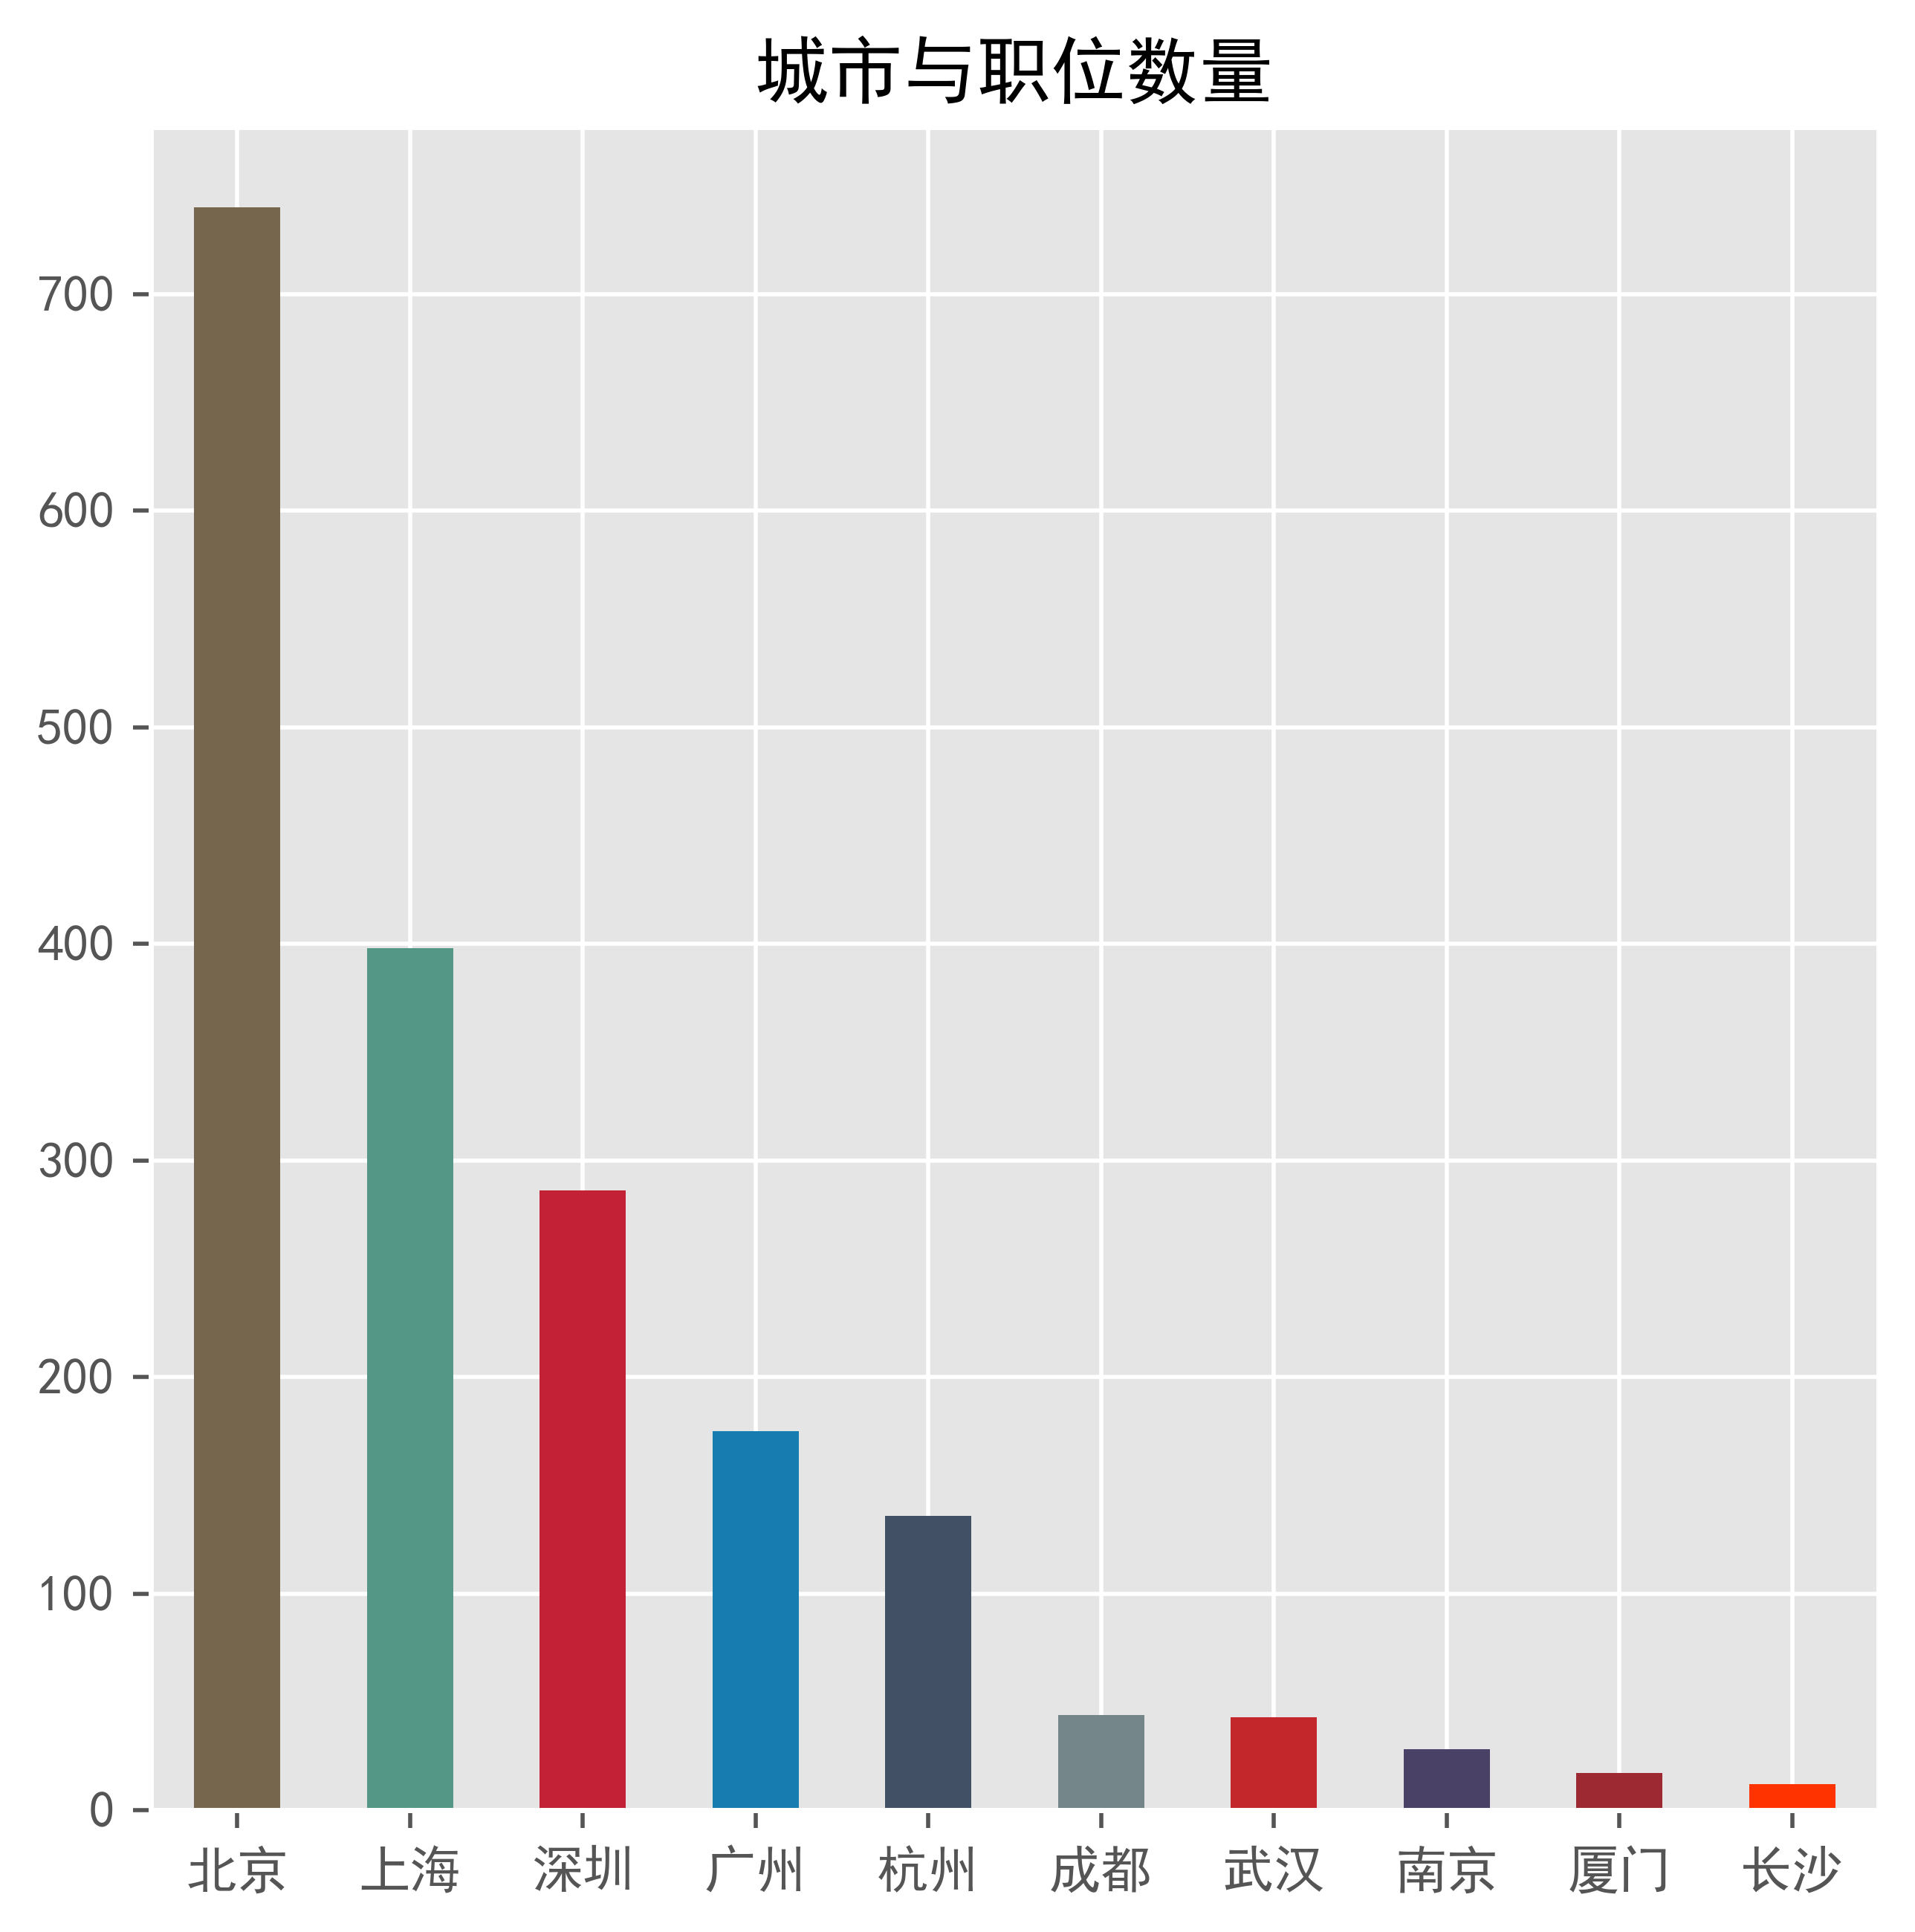

In [107]:
data['城市'].value_counts().plot(kind = 'bar', color=randomcolor(10))
plt.title('城市与职位数量')
plt.xticks(rotation=360) #rotation控制x轴标签倾斜角度

In [109]:
data.loc[data['城市'] == '杭州', '公司简称'].value_counts()[:5]

霖梓控股            7
云集              5
网易              5
浙江执御信息技术有限公司    4
大搜车             4
Name: 公司简称, dtype: int64

* 看看这10个城市，招聘职位数量前五的公司分别是哪些
* 通过定义一个函数topN来实现

In [110]:
def topN(dataframe, n=5):
    counts = dataframe.value_counts()
    return counts[:n]
data.groupby('城市')['公司简称'].apply(topN).loc[list(city.index)]

城市               
上海  拼多多              19
    字节跳动             10
    GeexFinance       7
    趣头条               7
    携程                7
北京  字节跳动             70
    美团点评             21
    京东数字科技           15
    数美               14
    车好多集团            12
南京  SHEIN             3
    指南者教育             2
    vivo              2
    卓尔智联集团有限公司        2
    网思科平              1
厦门  趣店                3
    福建天闻              2
    朗新科技              1
    美亚柏科              1
    游动网络              1
广州  网易                7
    租租车               5
    荔枝                5
    美的集团IT            4
    巴图鲁公司             3
成都  有利网               3
    锦程消费金融公司          2
    初灵信息              2
    西瓜创客              2
    映潮科技              2
杭州  霖梓控股              7
    云集                5
    网易                5
    浙江执御信息技术有限公司      4
    大搜车               4
武汉  字节跳动              5
    斗鱼直播              4
    福韵数据服务有限公司        3
    小药药集团             2
    易佰网络科技            2
深圳  腾讯               2

#### 3.2.2城市与薪资
* 以城市分组，看不同城市平均工资怎么样，发现薪资前五名中，厦门竟然在列，不过厦门样本量太小，数据不具有代表性，还是北上广深杭的天下

In [114]:
salary_by_city = data.groupby('城市')['工资下界'].mean()
salary_by_city.nlargest(10).round(2)

城市
北京    16051.42
深圳    14765.73
上海    14684.34
杭州    13948.53
厦门    12588.24
广州    11582.86
南京    10428.57
武汉    10069.77
成都     8704.55
长沙     7916.67
Name: 工资下界, dtype: float64

* 下面两块代码是为了画pehcarts包的图，如前面所说存成HTML，不在这里放的
* 加一个排序后city_salary_sorted，是因为上面用groupby聚合得到的均值，顺序是乱的，既不是按值排序，也不是按原标签顺序

In [115]:
city_salary_sorted = salary_by_city.nlargest(10).round(2)

In [117]:
bar = pyecharts.Bar('各城市的平均薪资')
bar.add(name='',x_axis=city_salary_sorted.index, y_axis=city_salary_sorted, xaxis_label_textsize=15,
        yaxis_label_textsize=20, is_label_show=True)

bar._option['series'][0]['itemStyle']={
                            'normal': {
                                'color': '#006666',
                            }
                        }
bar.render('各城市的平均薪资.html')#写这个是因为pyecharts也不好设置颜色，都一个毛病

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

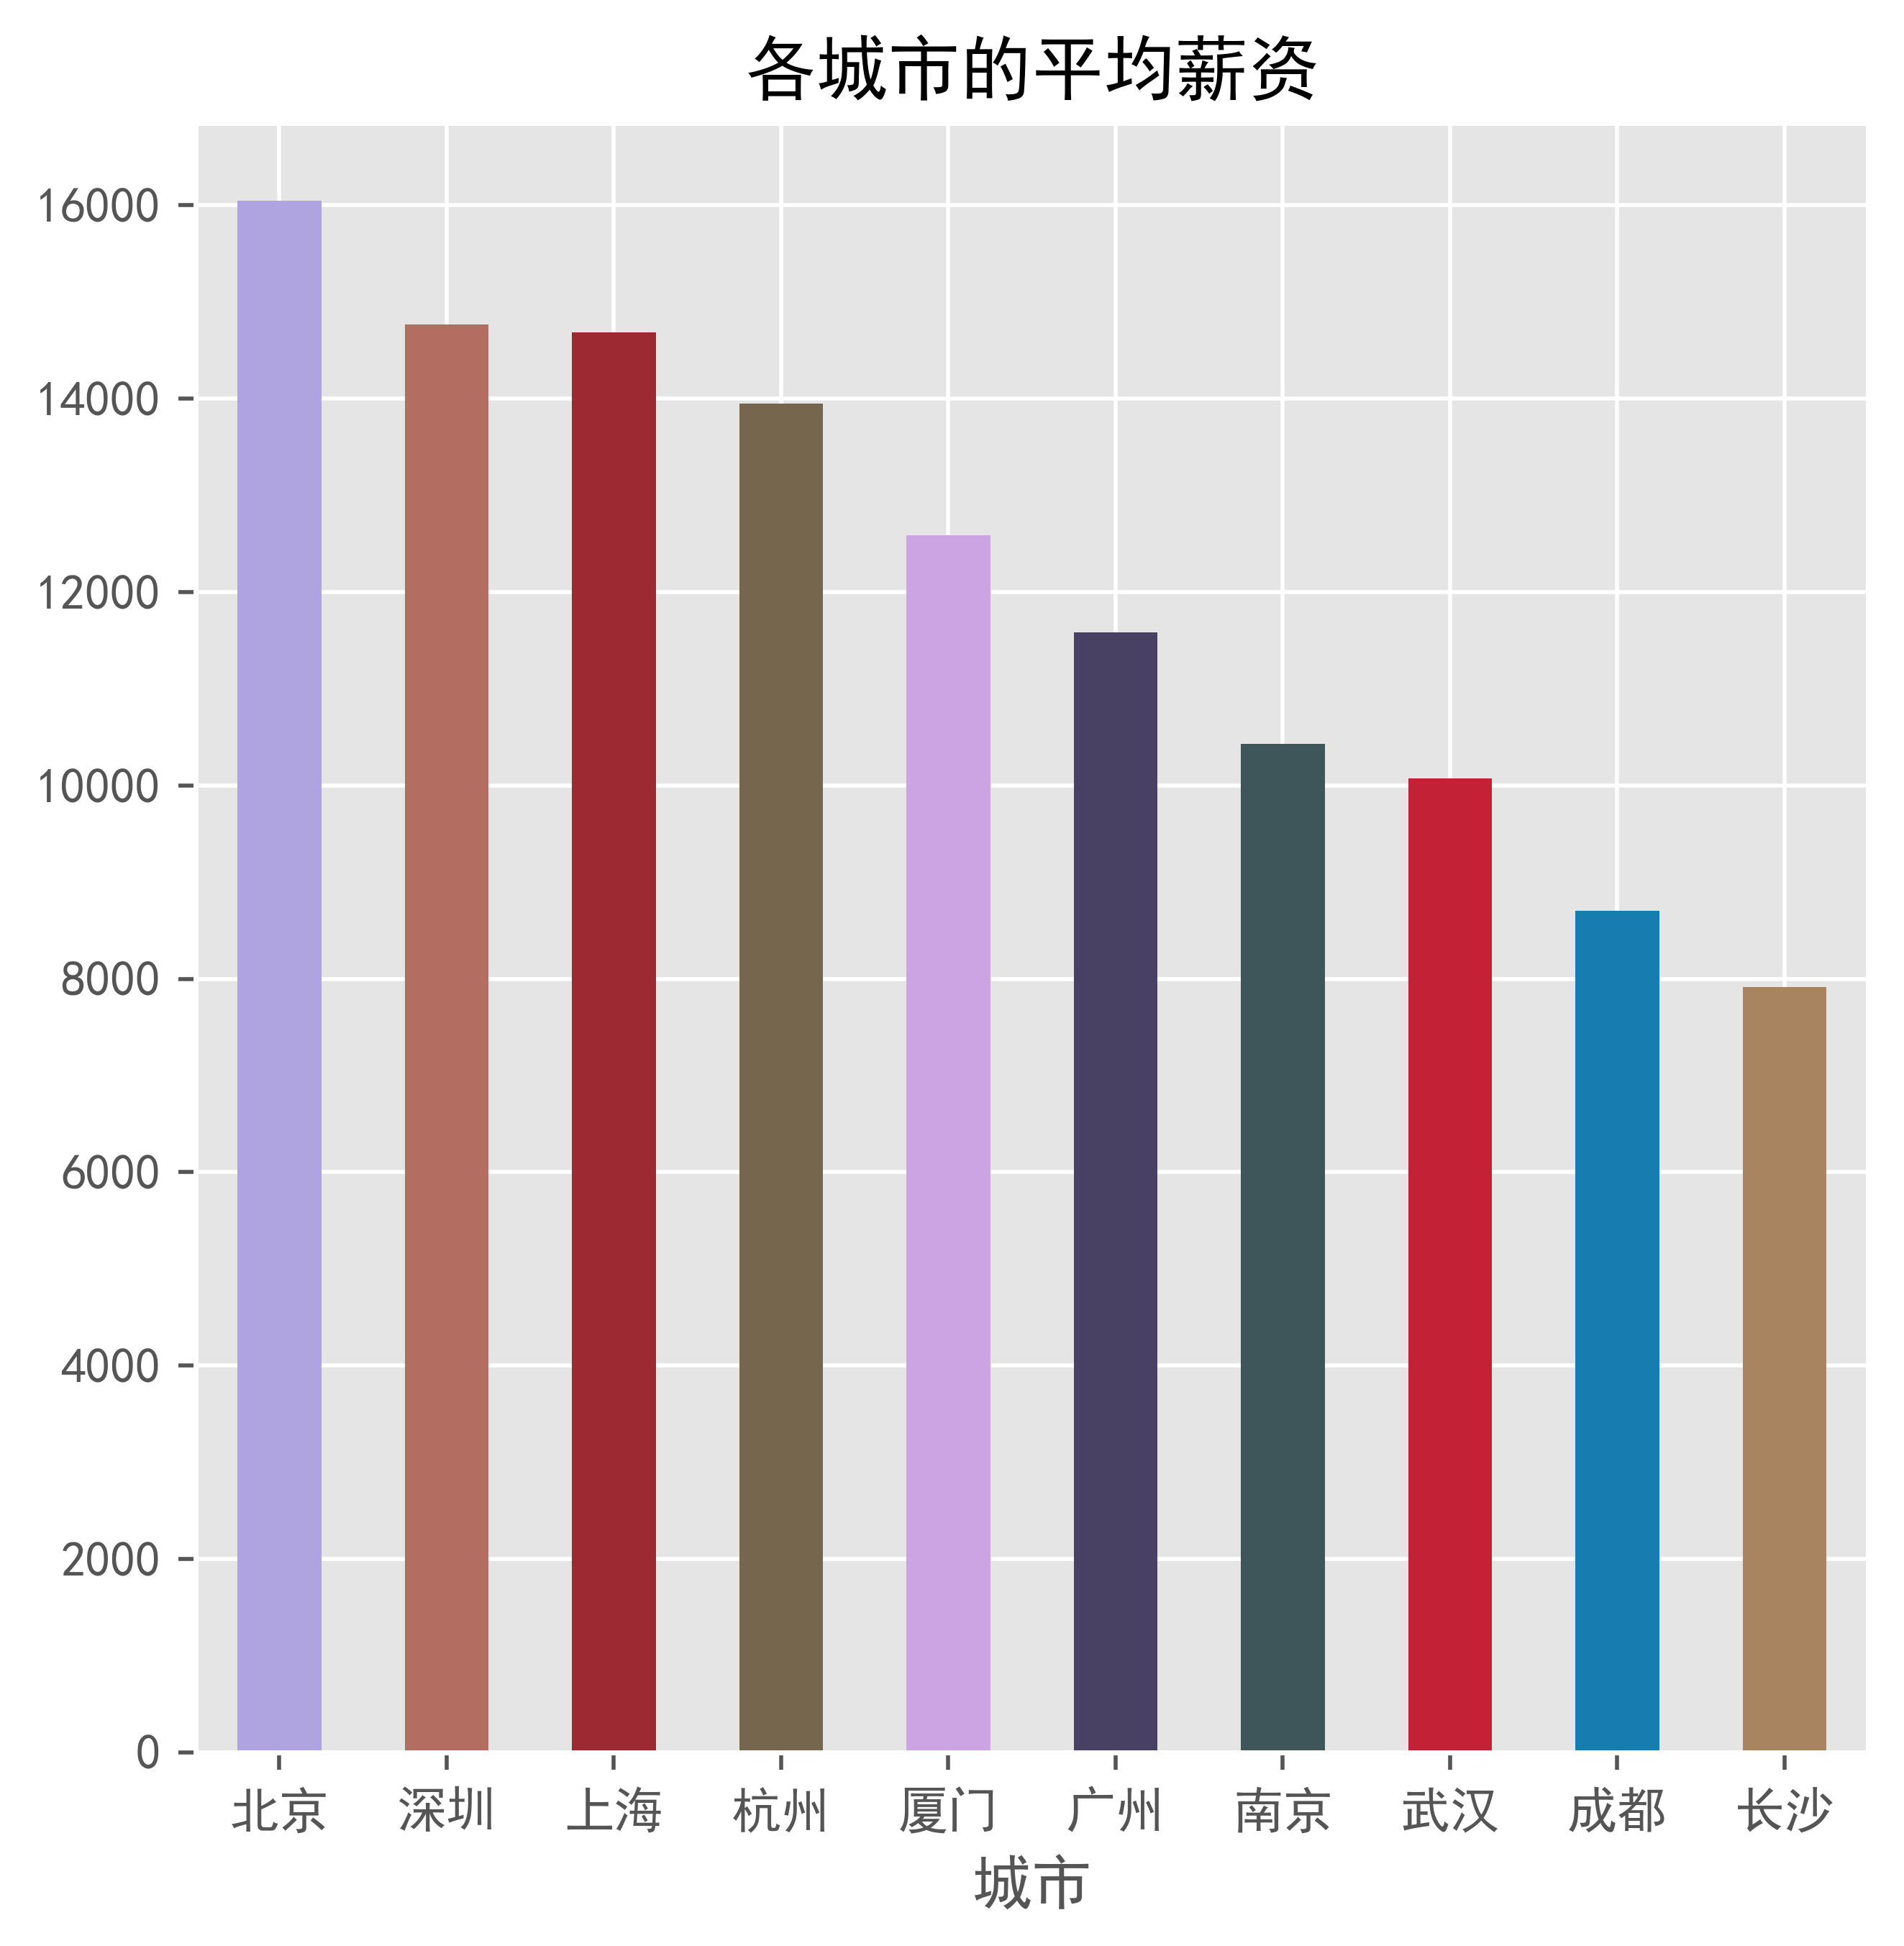

In [121]:
city_salary_sorted.plot(kind = 'bar', color=randomcolor(10))
plt.title('各城市的平均薪资')
plt.xticks(rotation=360) #rotation控制x轴标签倾斜角度

* 画个小提琴图，看看这些城市实习薪资的分布怎么样
* 从图中看，开出行业顶级高薪的，还得是北上深杭

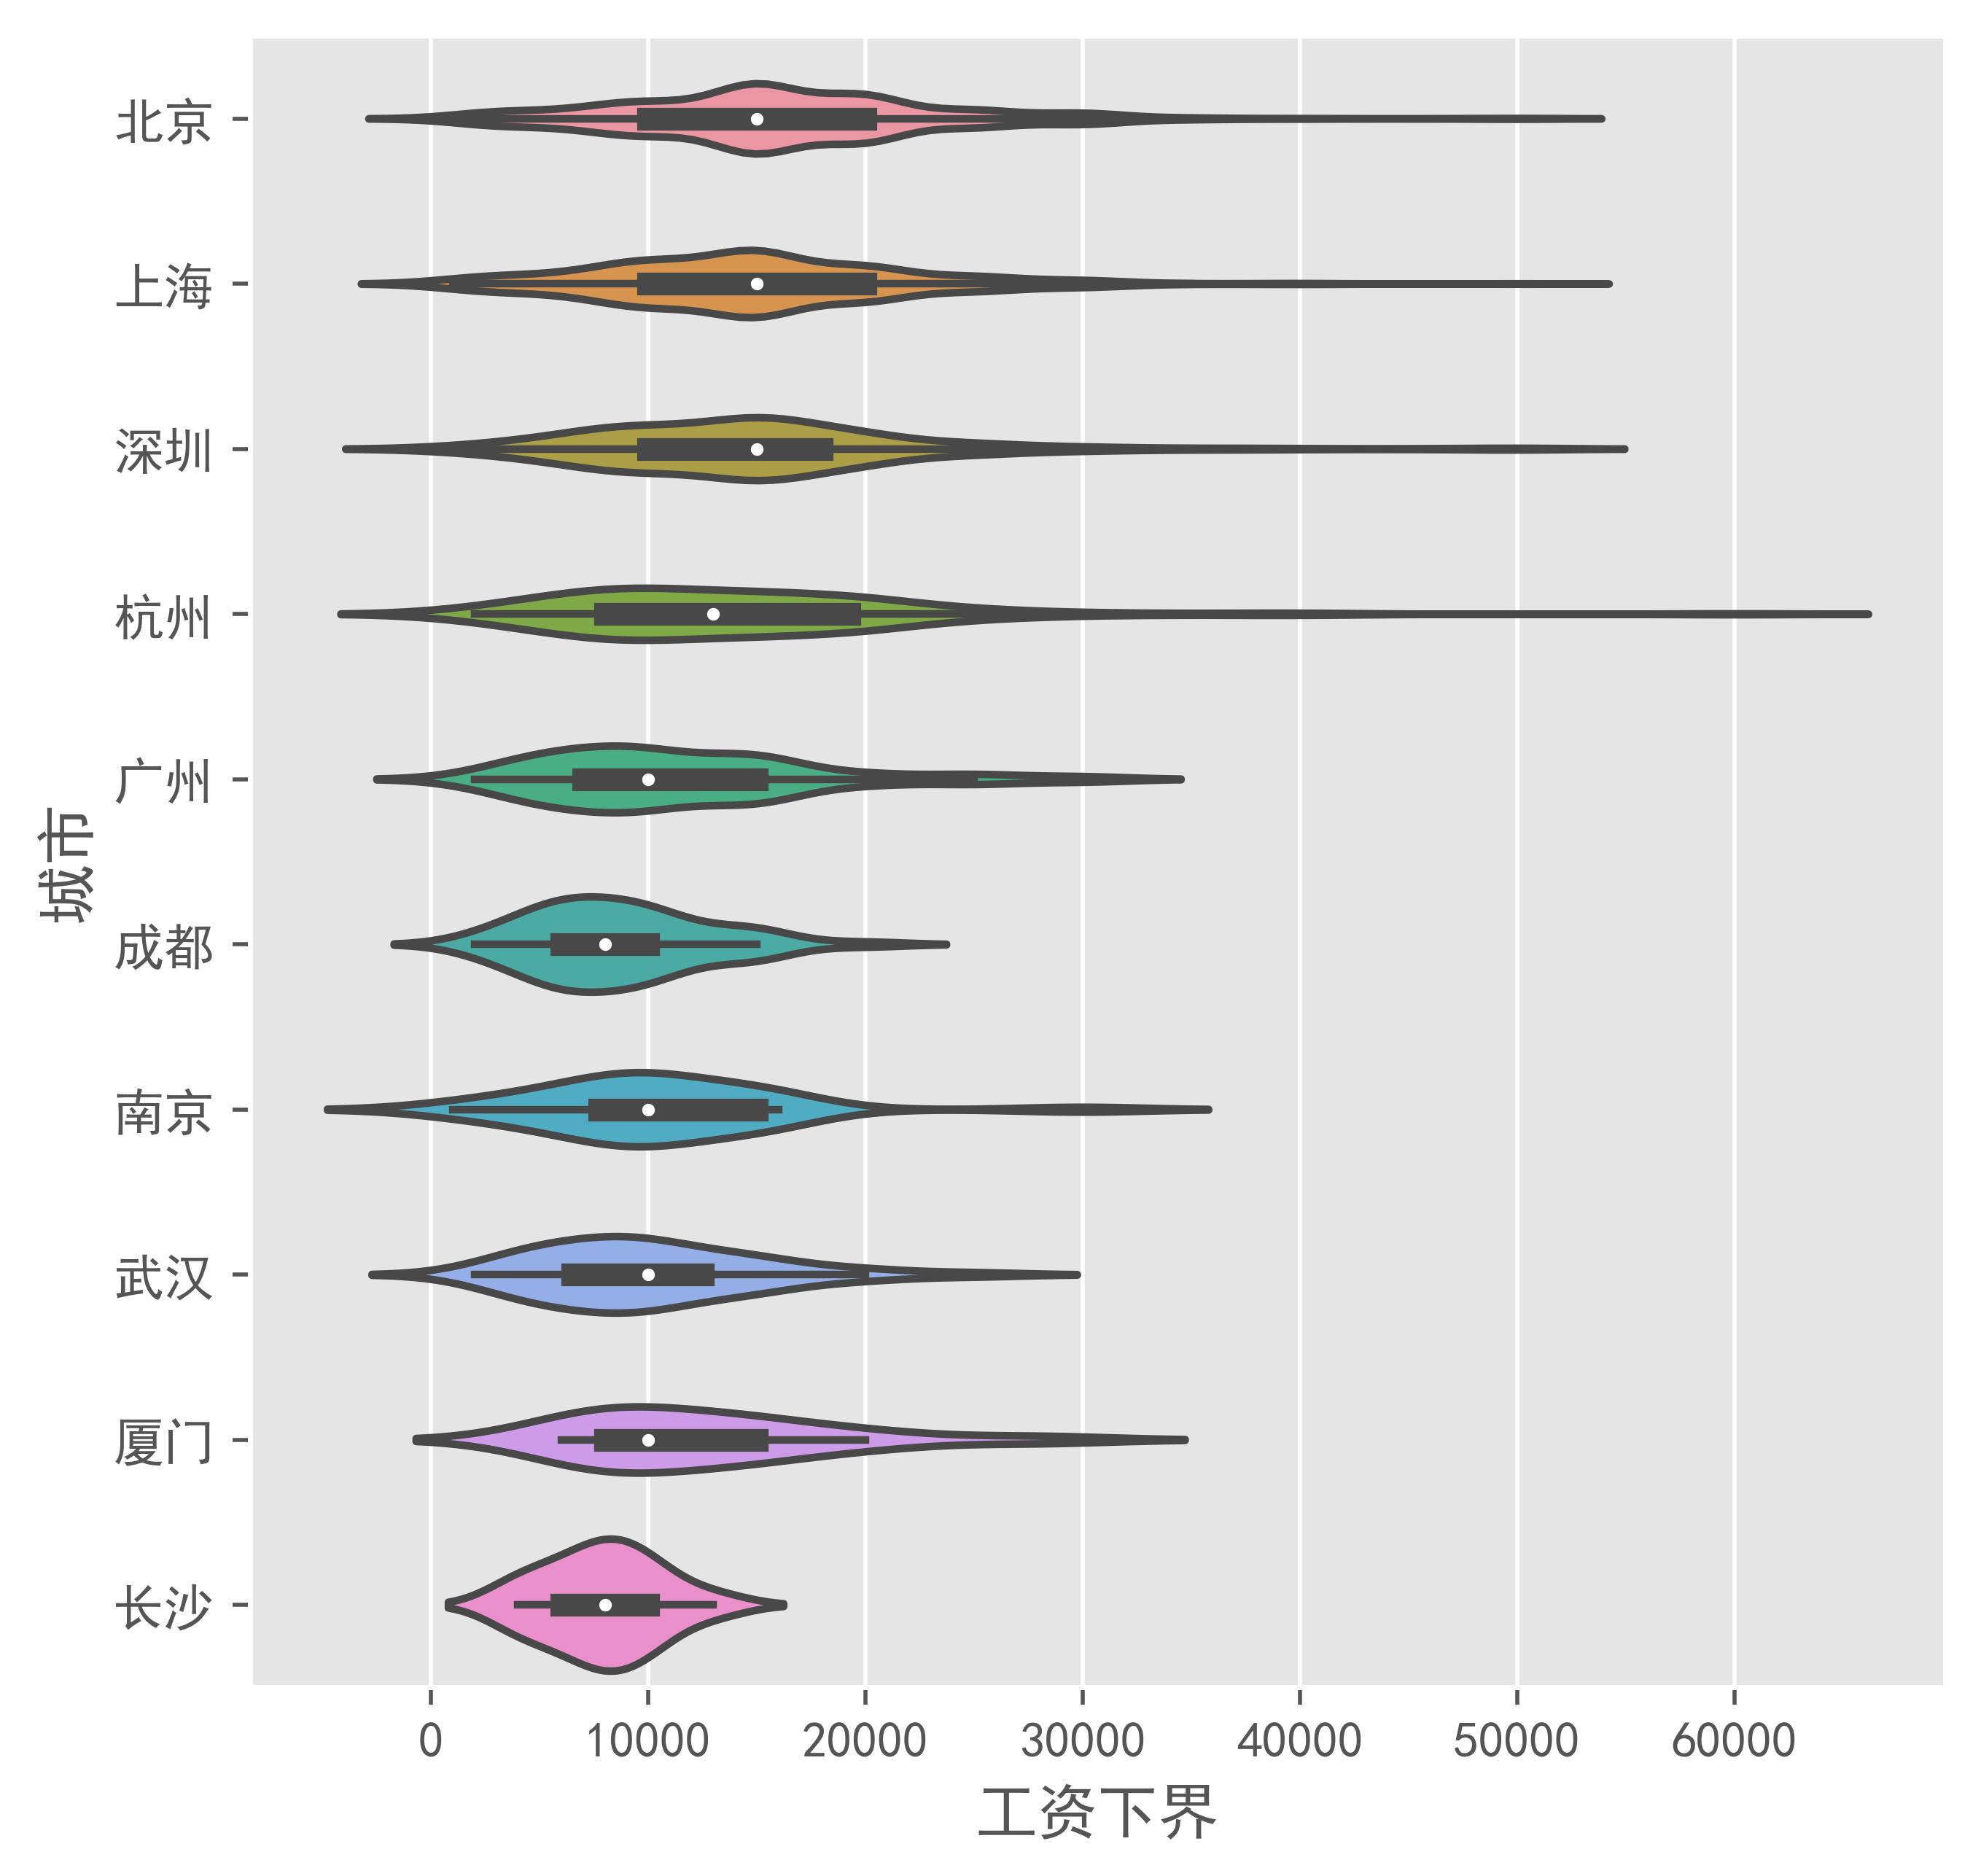

In [122]:
sns.violinplot(x ='工资下界', y ='城市', data = data, width = 0.8)

### 3.3学历
#### 3.3.1学历与职位数量
* 要求至少本科毕业的数量是最多的，约占83.6%
* 要求博士以上的最少，毕竟相对于机器学习和数据挖掘之类的岗位，数据分析算是对技术要求相对较低的
* 写学历不限的，多半是字段里填不限，但是在详情里要求了学历

In [124]:
job_degree = data['学历要求'].value_counts()

In [125]:
job_degree

本科    1570
不限     128
硕士      92
大专      87
博士       2
Name: 学历要求, dtype: int64

In [126]:
degree_pct = (job_degree/job_degree.sum()).map(lambda x: '{:,.2%}'.format(x))
degree_pct

本科    83.56%
不限     6.81%
硕士     4.90%
大专     4.63%
博士     0.11%
Name: 学历要求, dtype: object

In [109]:
pie = pyecharts.Pie('数据分析岗学历要求')
pie.add('',job_degree.index, job_degree.values, is_label_show=True)
pie.render('数据分析岗学历要求.html')

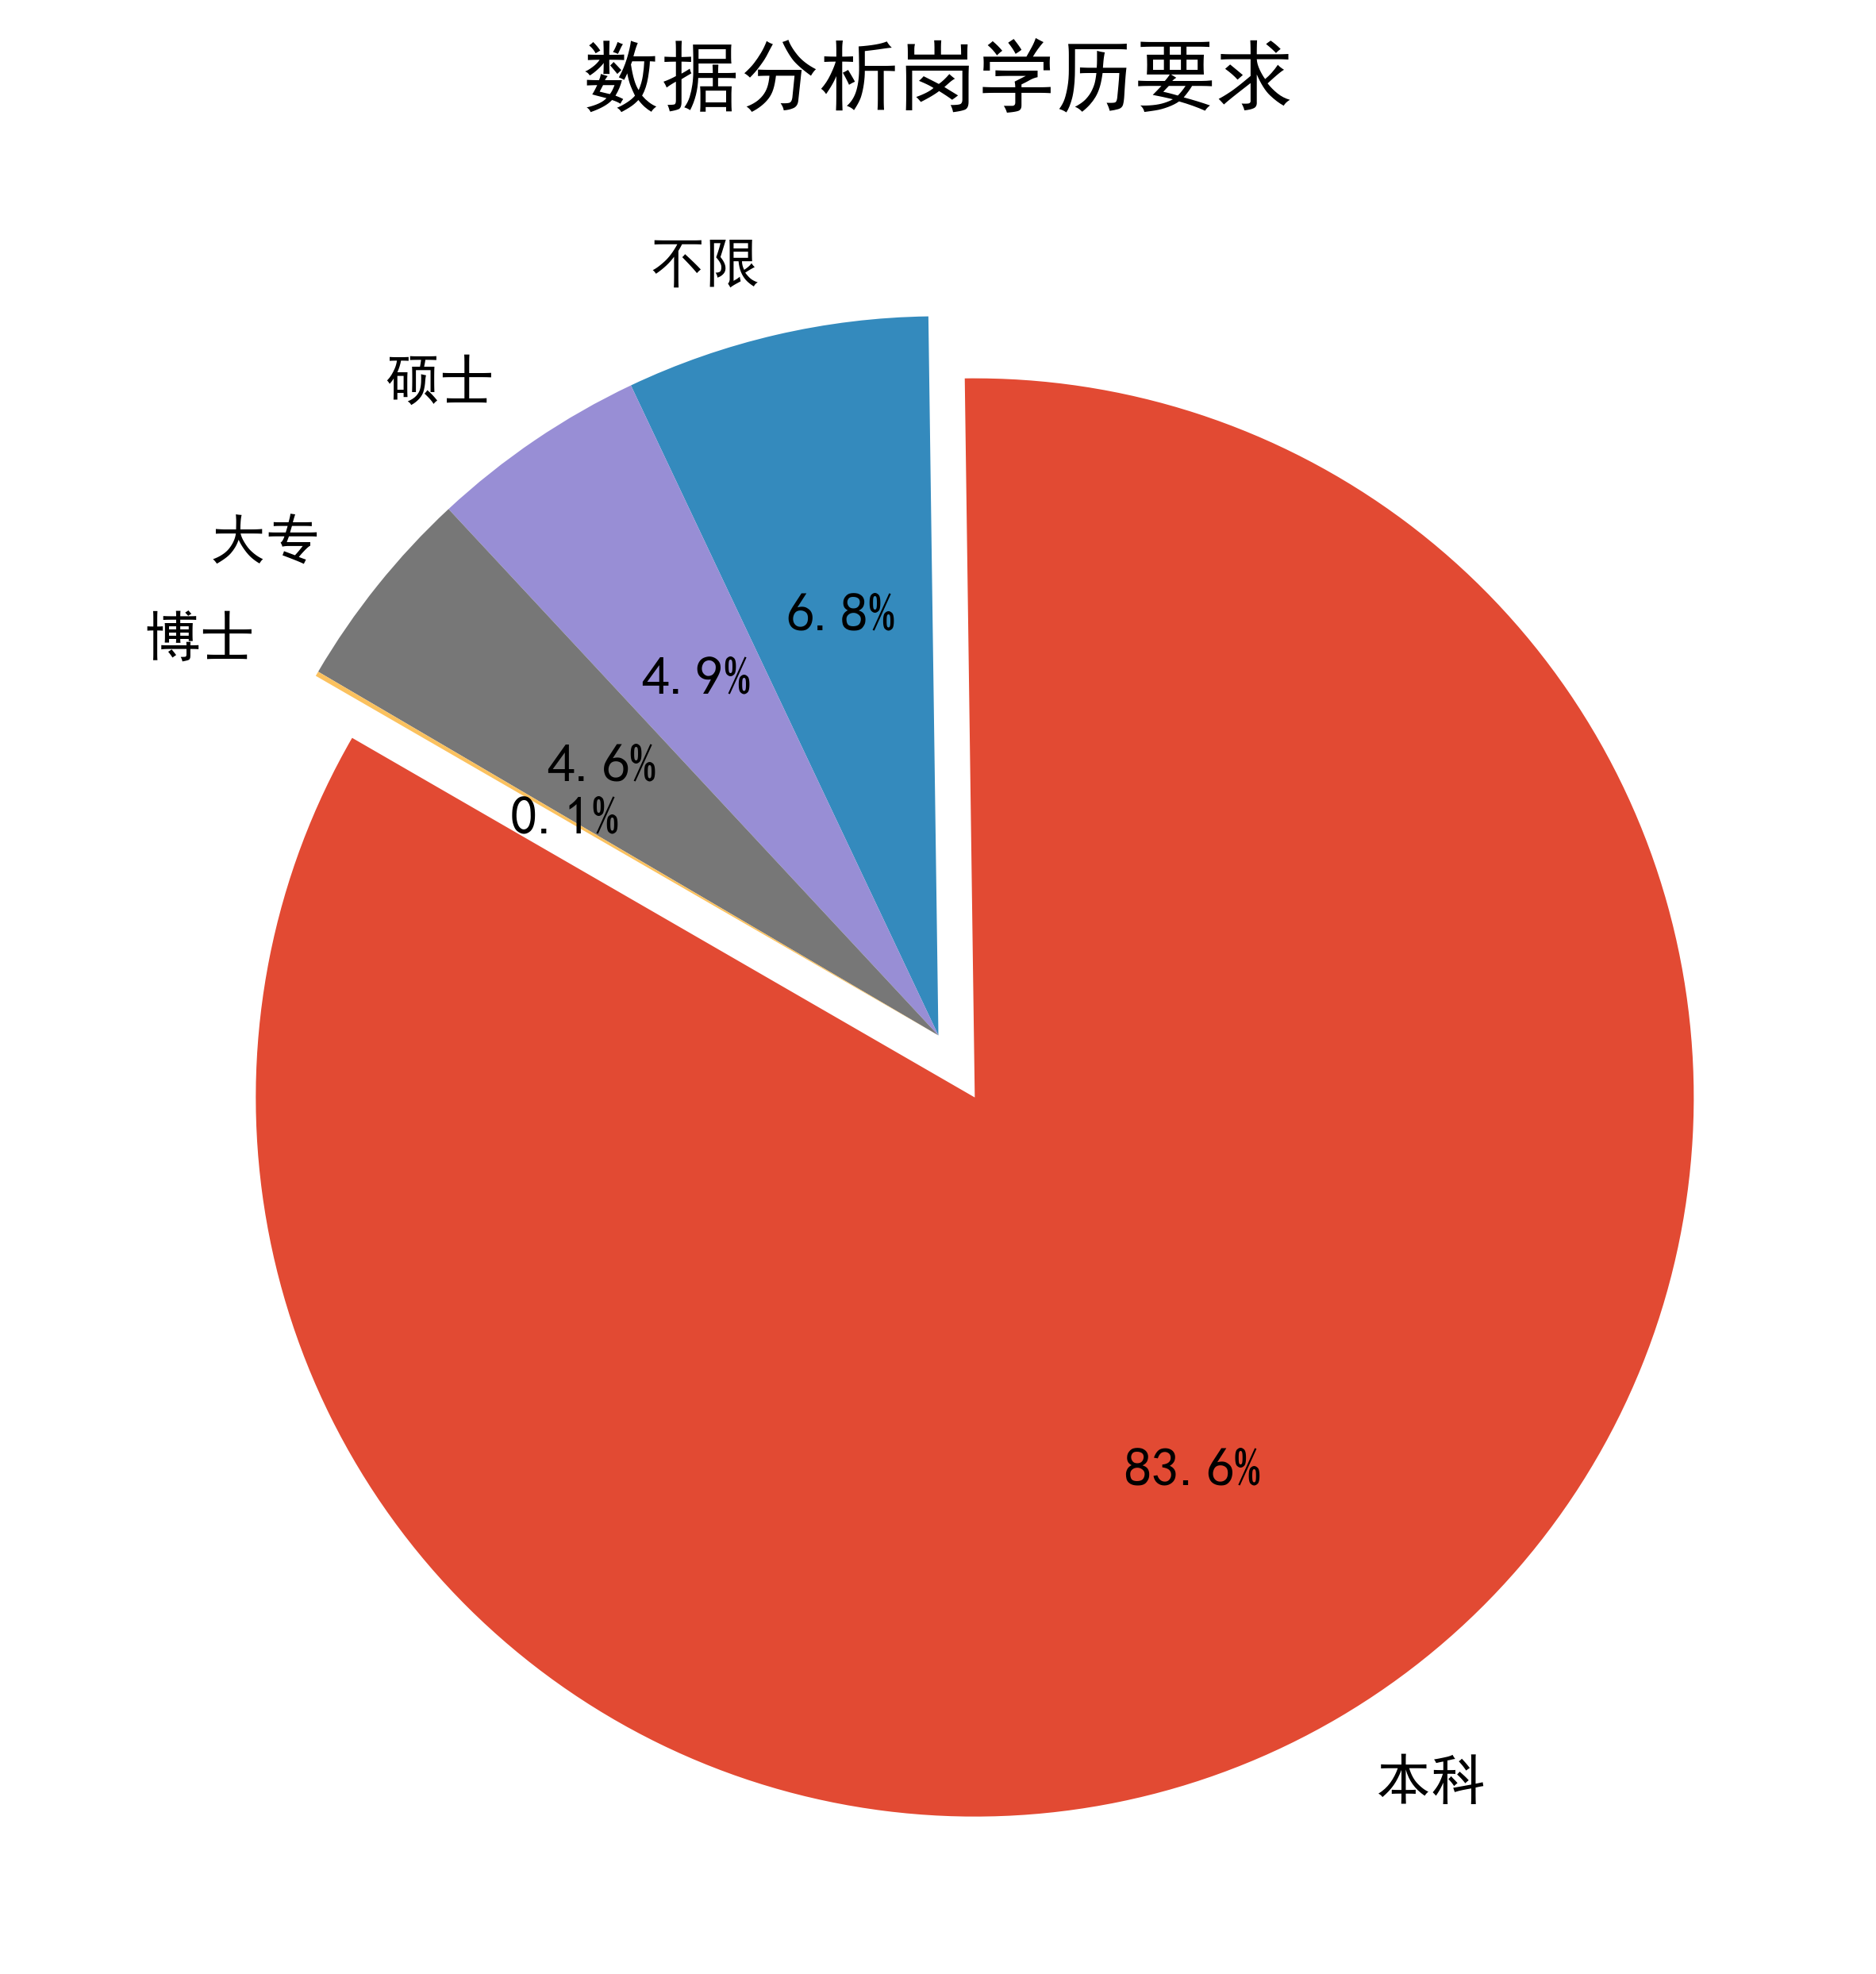

In [134]:
plt.pie(job_degree,explode=(0.1,0,0,0,0),labels=job_degree.index,autopct='%1.1f%%',shadow=False,startangle=150)
plt.title("数据分析岗学历要求")
plt.show()

#### 3.3.2 学历与薪资
* 再看看薪资和学历有什么关系。发现基本上是正相关的关系，博士最高，接着是硕士、本科、大专

In [135]:
data.groupby('学历要求')['工资下界'].mean().sort_values().round(2)

学历要求
大专     8505.75
不限    13429.69
本科    14893.43
硕士    15250.00
博士    20500.00
Name: 工资下界, dtype: float64

* 在这个箱形图中，本科有很多离群值,可以想到是因为工作经验的影响

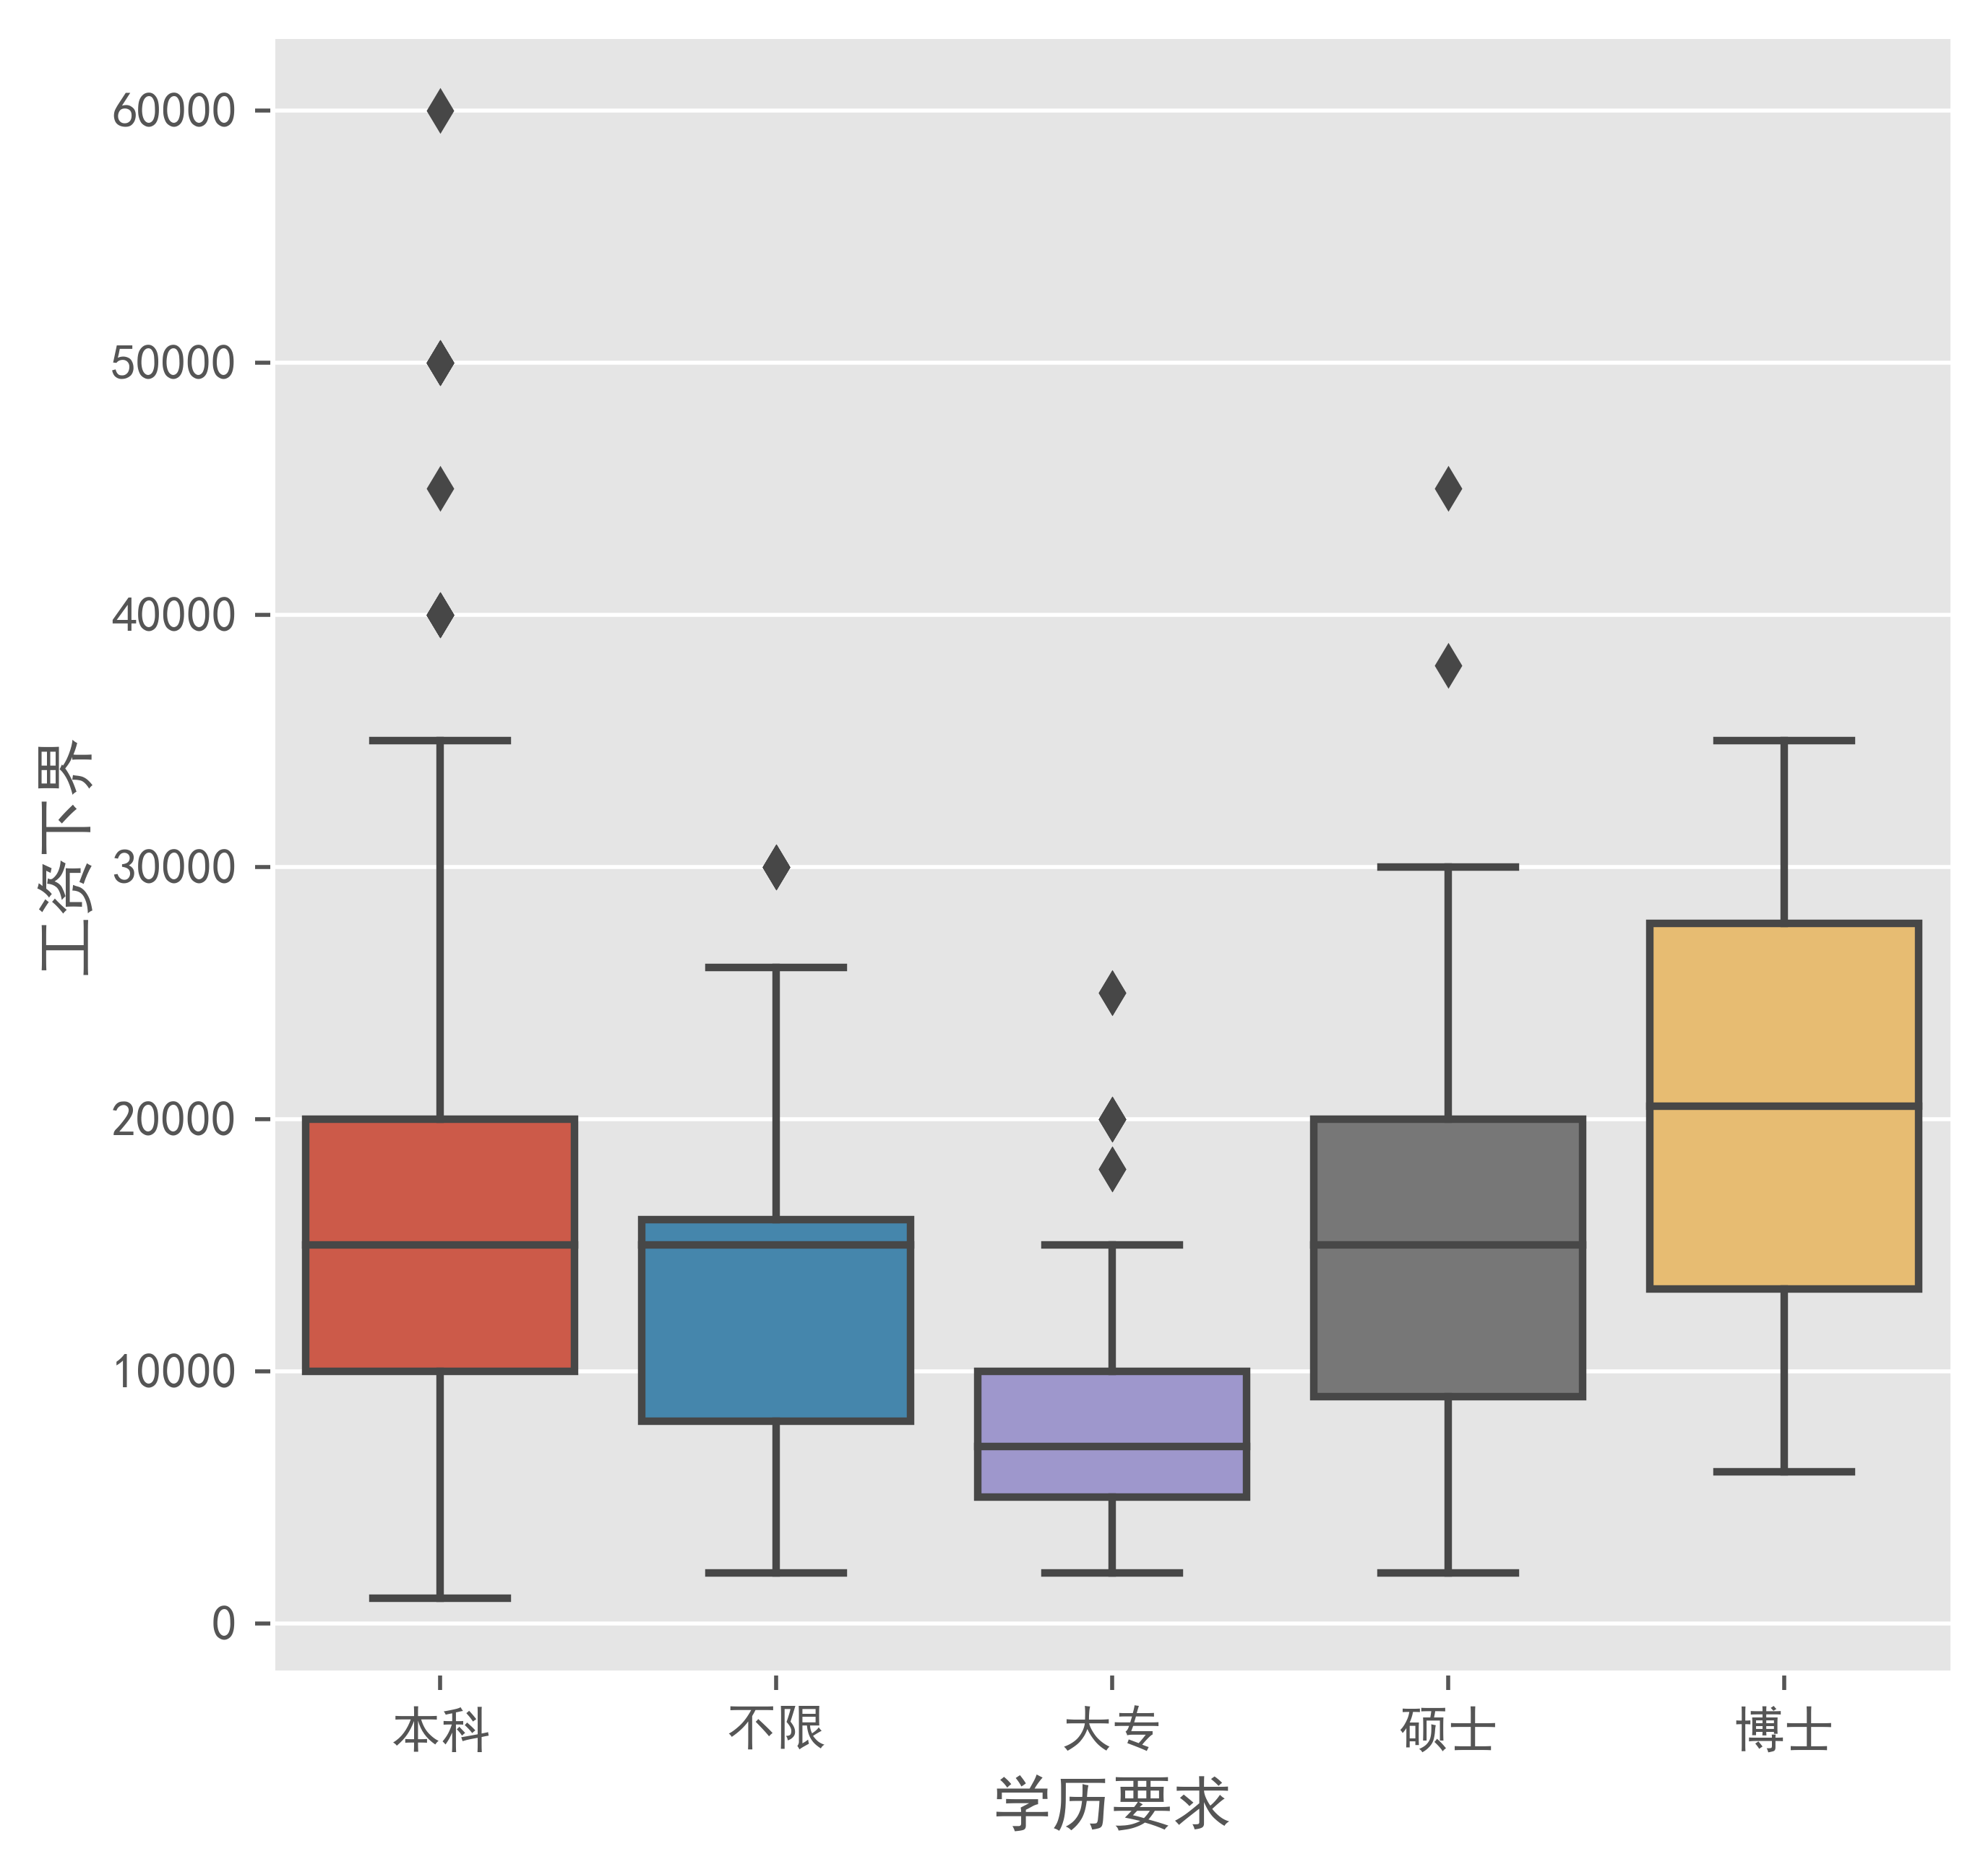

In [141]:
sns.boxplot(x='学历要求', y='工资下界', data= data,)

### 3.4工作经验
#### 3.4.1工作经验与职位数量
* 要求3-5年的最多，占比41.6%，加上1-3年25.0%，和5-10年的14.4%，总共有81.0%
* 而应届毕业生和一年以下的只占8.1%，都表明了公司想要又年轻又有经验的熟练工
* 至于要求10年以上经验的，只有0.3%，第一是这个级别一般不在招聘网站交易，第二是中国的数据分析行业也就是从3-4年前左右才开始比较快的发展
* 而那10.8%不限的，还是那句老话，都在详情里要求了经验，不是1-3年，就是3-5年

In [143]:
job_exp = data['工作经验'].value_counts()
job_exp

3-5年     781
1-3年     469
5-10年    270
不限       203
应届毕业生    125
1年以下      26
10年以上      5
Name: 工作经验, dtype: int64

In [145]:
exp_pct = (job_exp/job_exp.sum()).map(lambda x: '{:,.2%}'.format(x))
exp_pct

3-5年     41.56%
1-3年     24.96%
5-10年    14.37%
不限       10.80%
应届毕业生     6.65%
1年以下      1.38%
10年以上     0.27%
Name: 工作经验, dtype: object

In [122]:
pie = pyecharts.Pie('数据分析岗工作经验要求')
pie.add('',job_exp.index, job_exp.values, is_legend_show= False, is_label_show=True)
pie.render('数据分析岗工作经验要求.html')

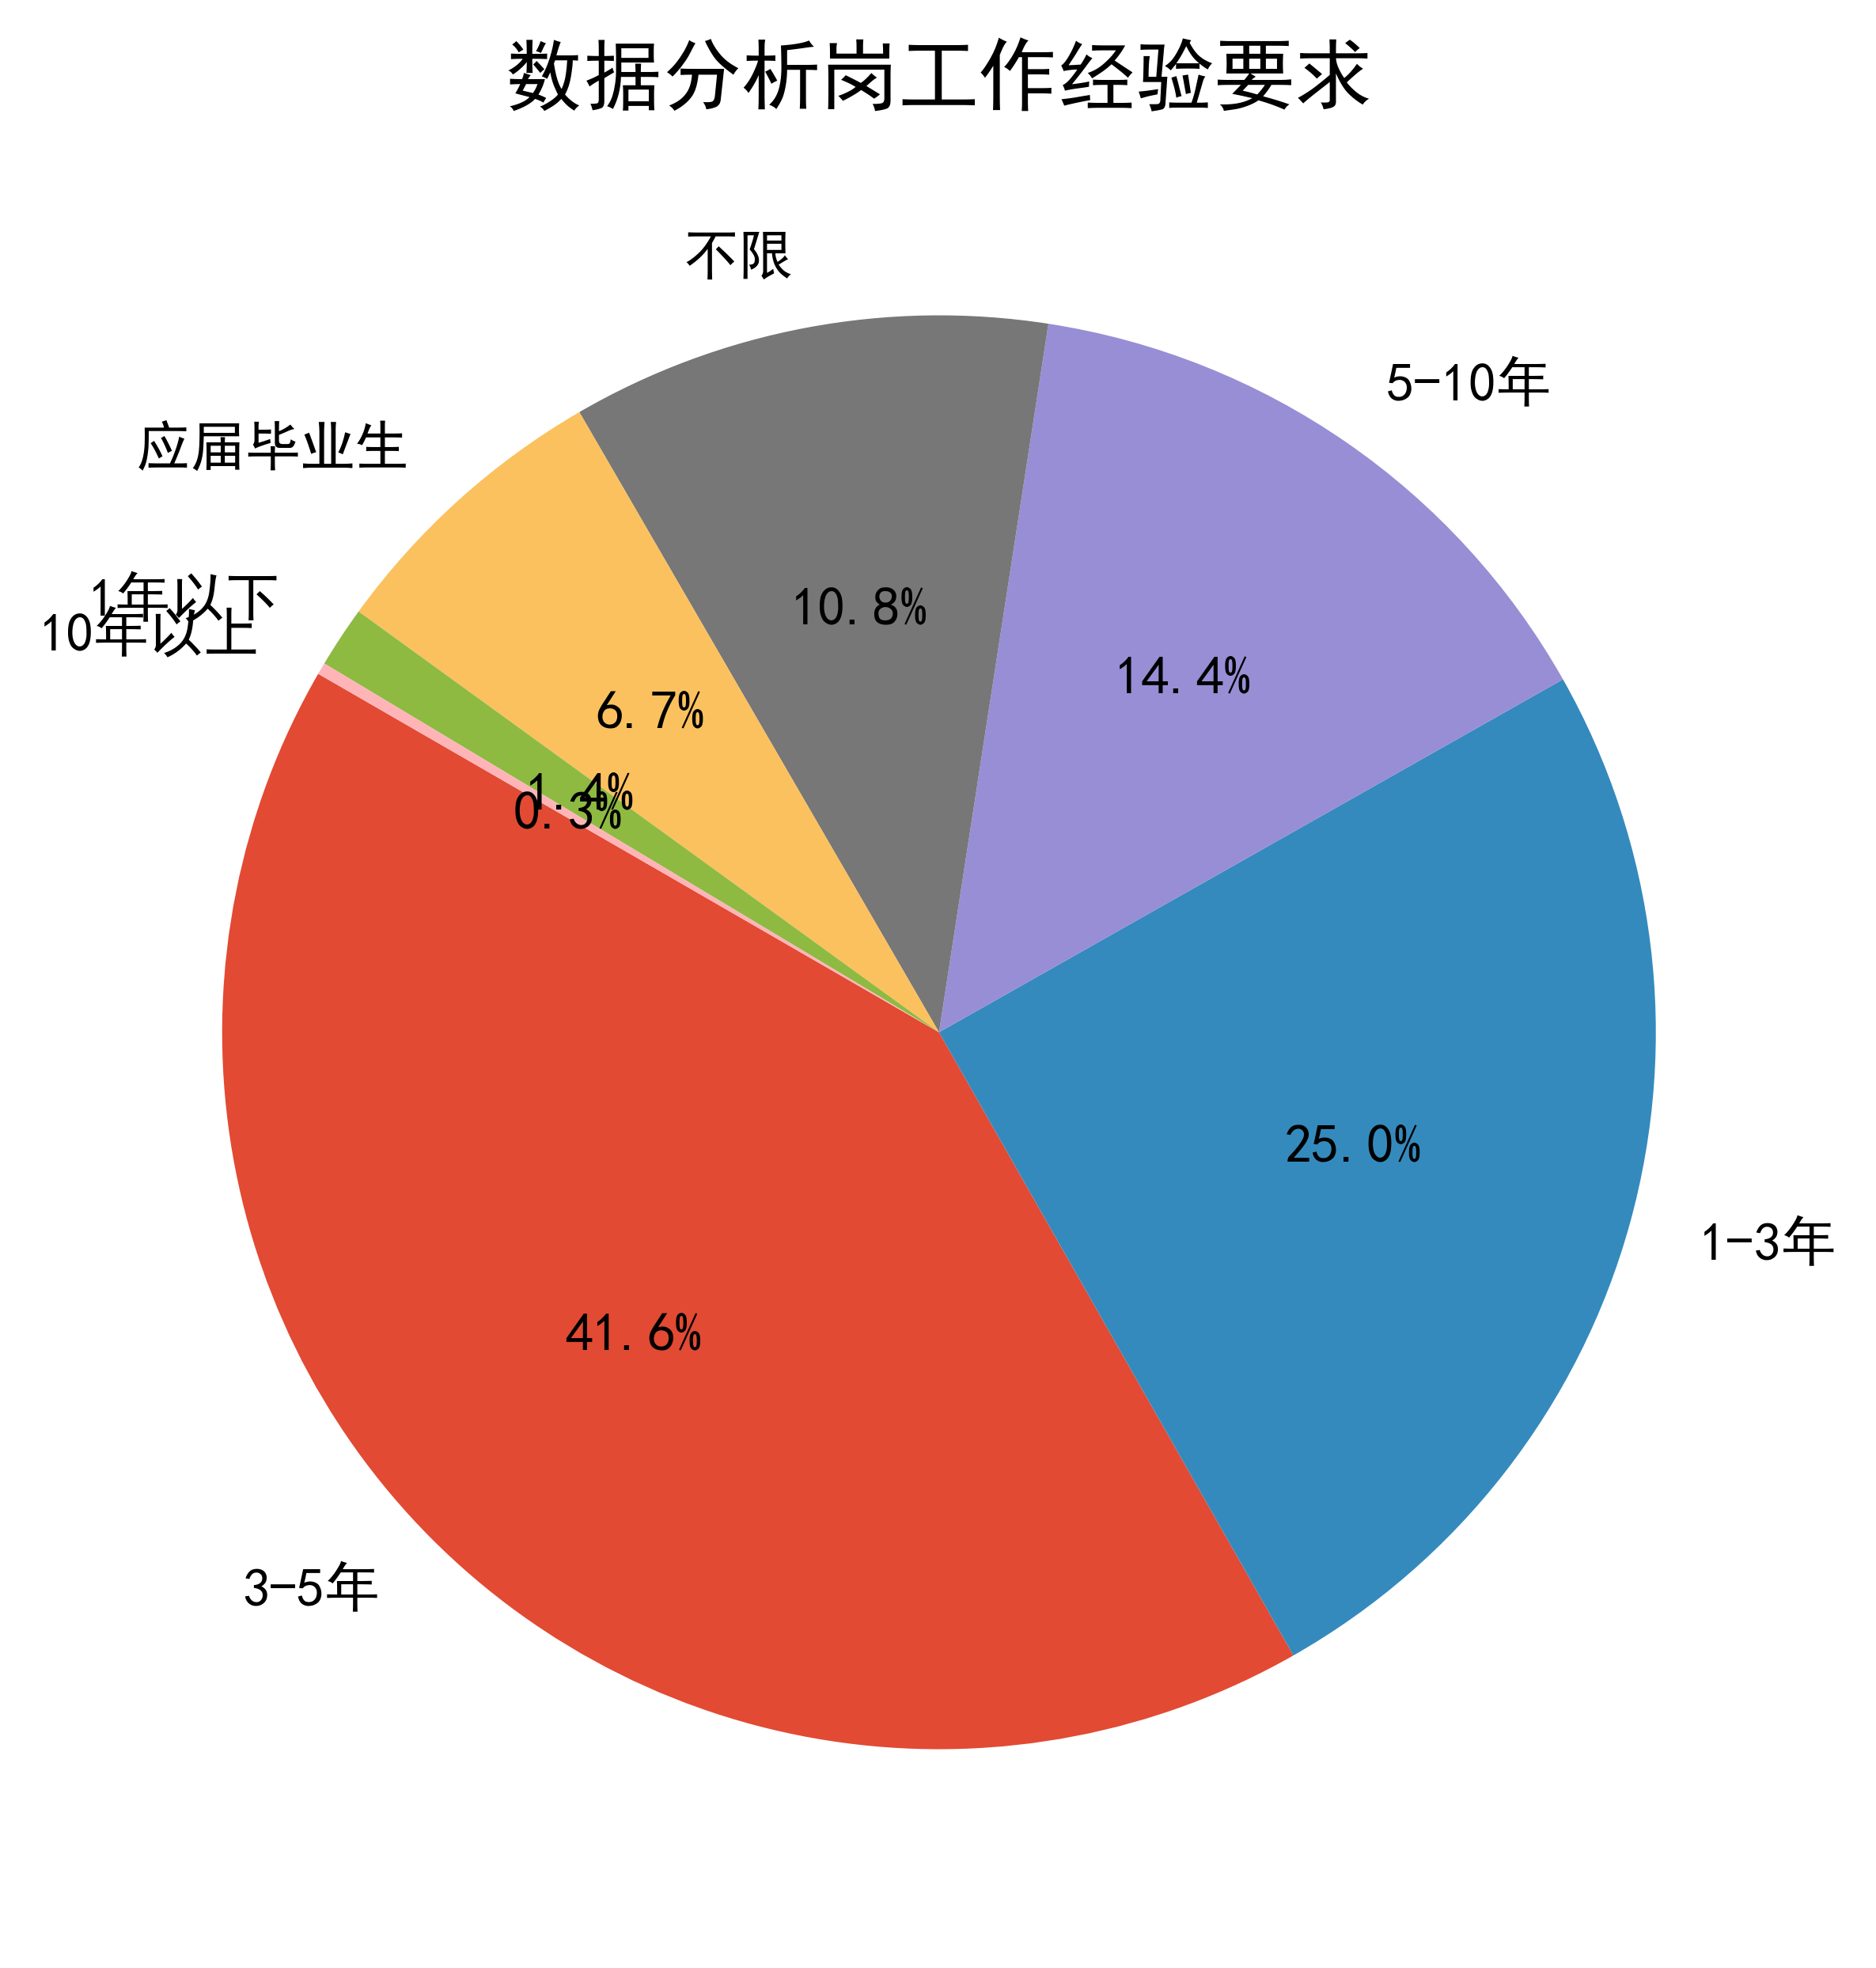

In [148]:
plt.pie(job_exp,labels=job_exp.index,autopct='%1.1f%%',shadow=False,startangle=150)
plt.title("数据分析岗工作经验要求")
plt.show()

#### 3.4.2工作经验与薪资
* 很直观的正相关关系，工作经验多薪资越高，说明这行的经验积累是有价值的，但是因为看重经验，所以同时也对新人不是很友好

In [150]:
exp_salary = data.groupby('工作经验')['工资下界'].mean().sort_values().round(2)
exp_salary

工作经验
应届毕业生     5952.00
1年以下      6653.85
不限       11004.93
1-3年     11212.45
3-5年     16207.43
5-10年    22211.11
10年以上    42000.00
Name: 工资下界, dtype: float64

* 从这个箱形图也可以看到，经验不限是假的，总体来说很接近要求1-3年经验的职位

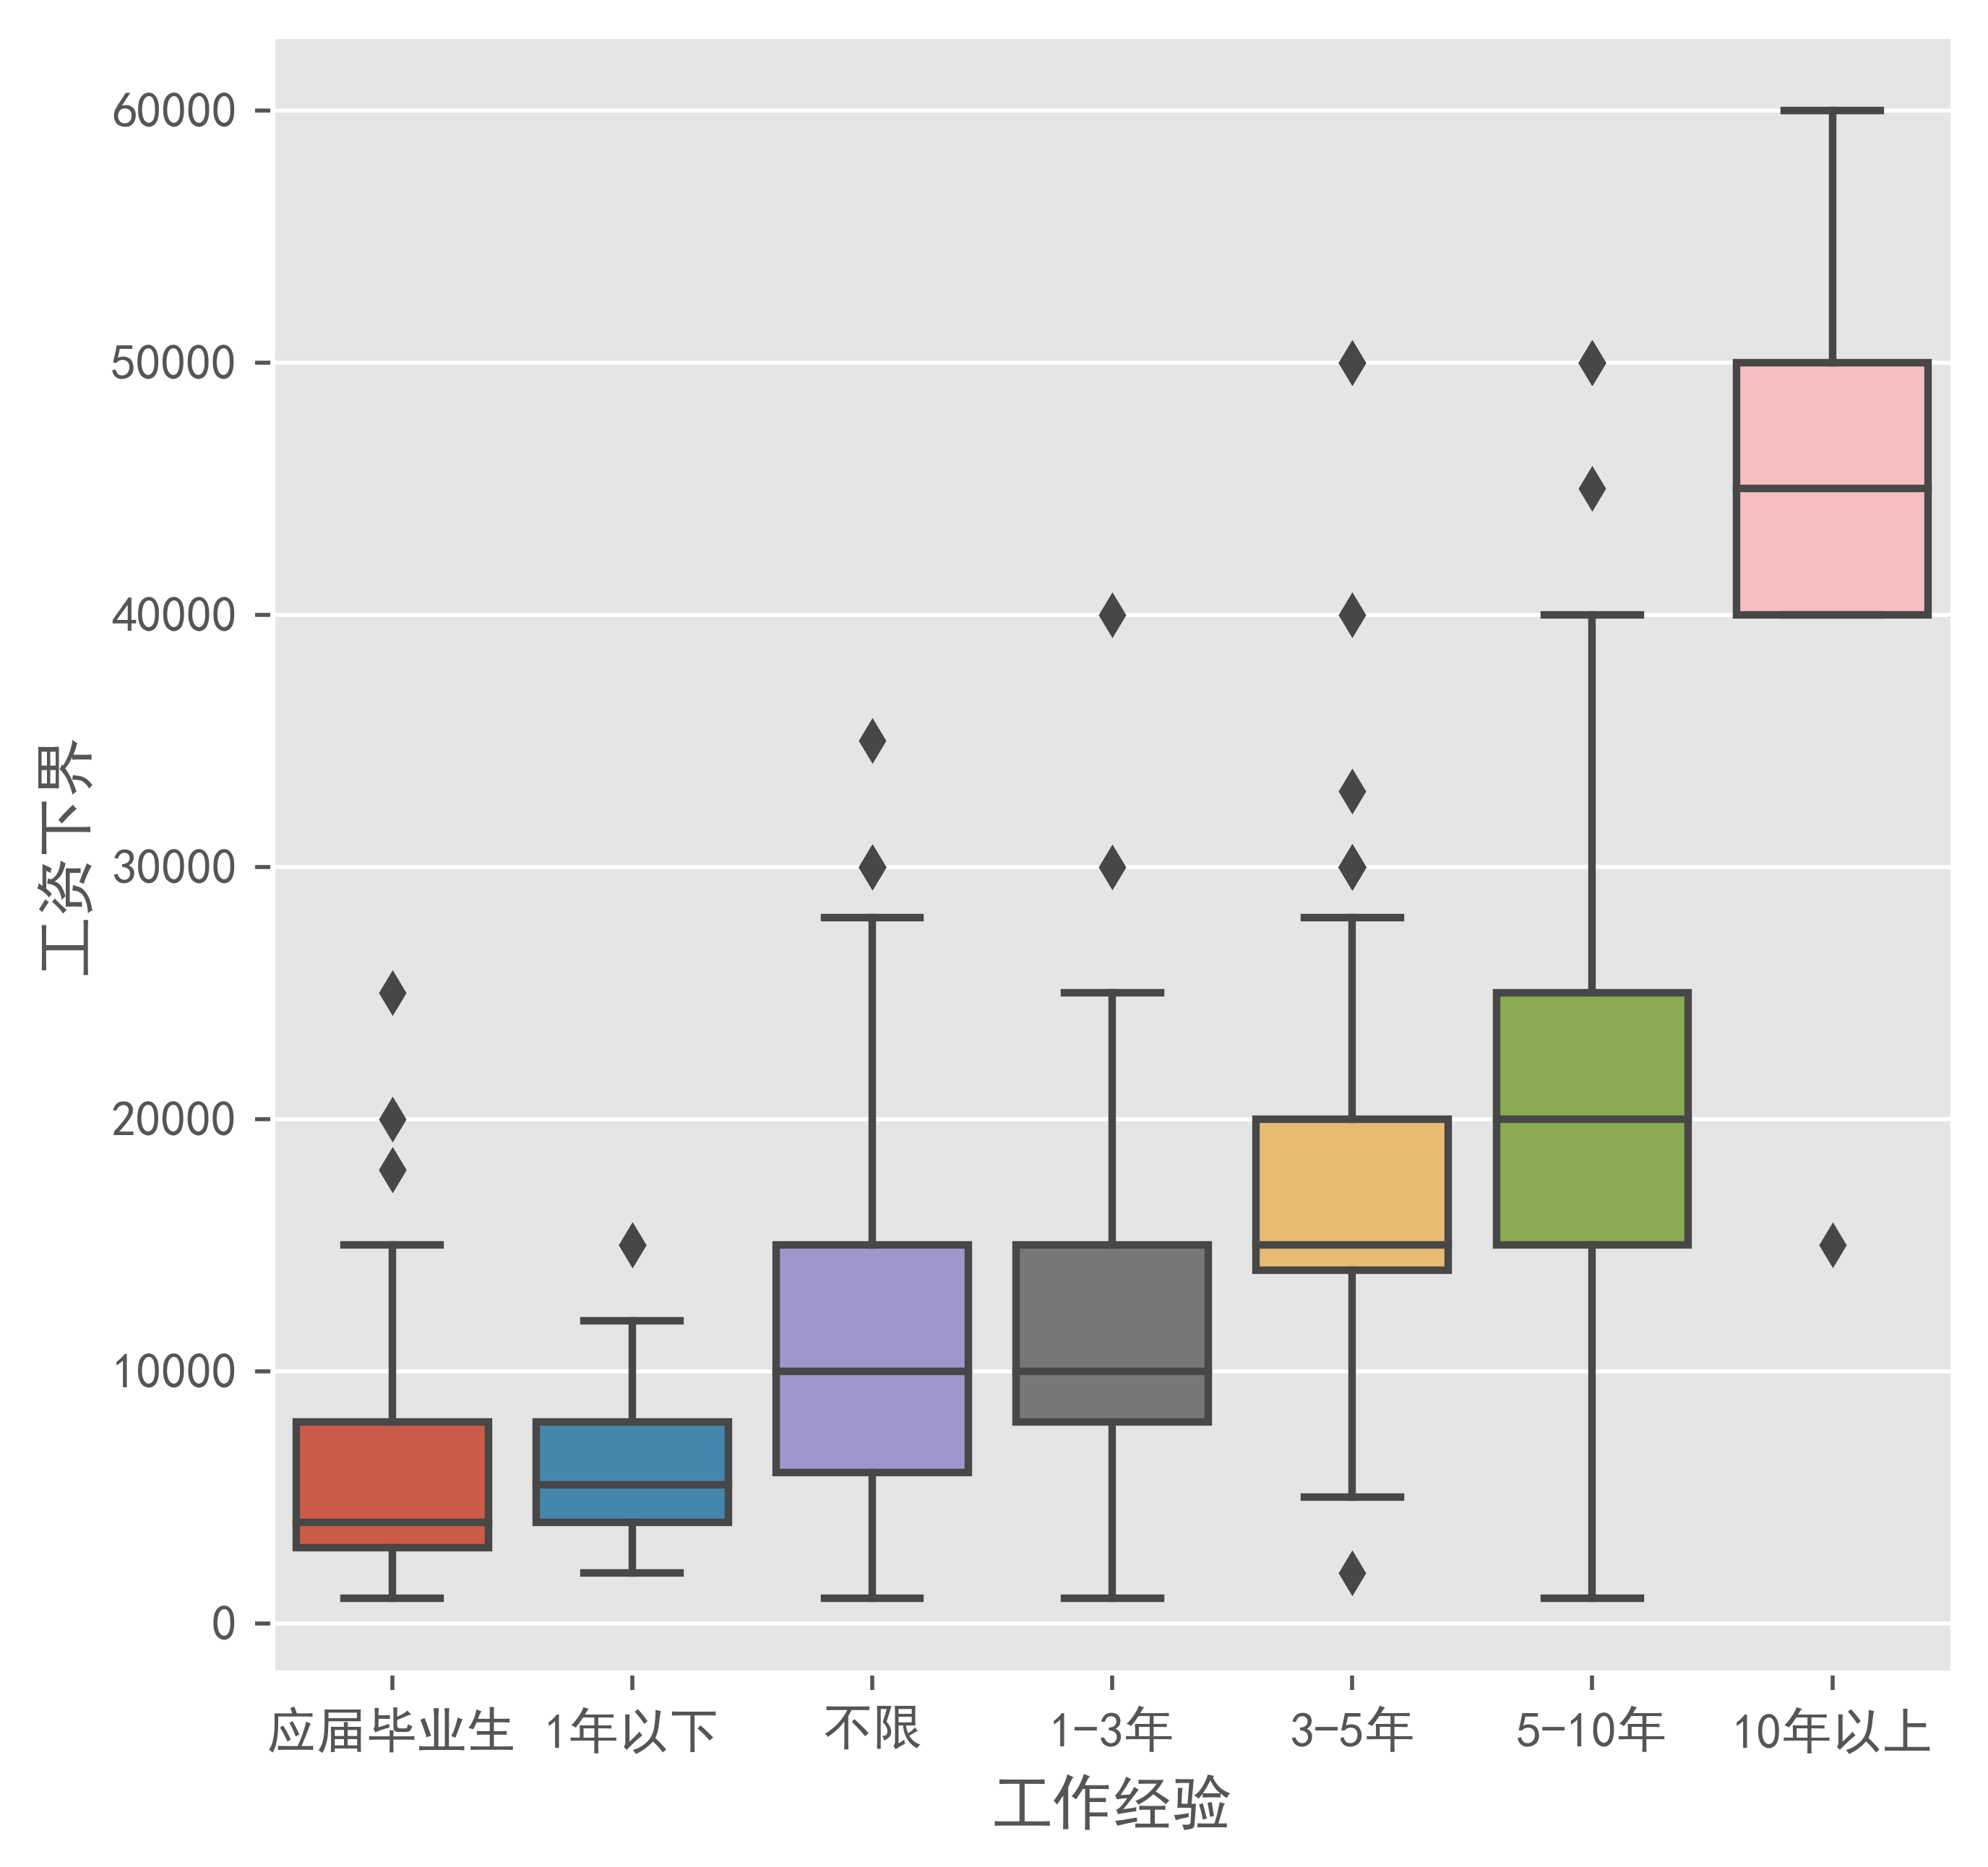

In [151]:
sns.boxplot(x='工作经验', y='工资下界', data= data, order= exp_salary.index)

### 3.5公司
有很多跟公司相关的字段，看看哪些公司现在招的职位数量最多，给出的薪资怎么样
* 在招职位数量前15的公司，多数是大家熟悉的知名公司
* 阿里巴巴和百度并不在列，我去阿里和百度的招聘官网看了，职能划分很细，而且都没有叫‘数据分析’的岗位
* 字节跳动一骑绝尘，真·数据驱动公司
* 字节跳动同时发布这么多数据分析岗，比如应聘者如果在一个职位的申请中被拒绝了，不知道是否还可以继续申请别的岗位

In [152]:
data.groupby('公司简称')['工资下界'].agg(['count', 'mean']).sort_values(by='count', ascending = False)[:15].round(2)

,count,mean
公司简称,,
字节跳动,98,15224.49
腾讯,26,19000.00
美团点评,24,14958.33
拼多多,19,19157.89
京东集团,19,18105.26
网易,16,20250.00
京东数字科技,16,20312.50
OPPO,16,17000.00
数美,14,10714.29


* ‘公司规模’2000人以上的公司发布的职位总数量最多，呈正相关，这方面的需求还是以大型企业为主
* 薪资总体来说也是大型企业给的高

In [153]:
data['公司规模'].value_counts()

2000人以上      775
500-2000人    390
150-500人     375
50-150人      229
15-50人        88
少于15人         22
Name: 公司规模, dtype: int64

In [154]:
data.groupby('公司规模')['工资下界'].mean().round(2).sort_values()

公司规模
15-50人       10750.00
少于15人        11150.00
50-150人      12384.28
150-500人     13812.83
500-2000人    13969.23
2000人以上      16286.45
Name: 工资下界, dtype: float64

* 我们看看这些职位都是什么时候发布的
* 我是8月14爬的数据，当天发布的竟然最多，那我们可以猜测这个‘发布时间’并非指职位首次发布的世界，而是指‘企业端有人检查过这个职位的简历投递情况’或者‘更新过职位信息’之类的操作
* 不过这个‘发布时间’越新越能够说明，背后的企业是真的在拉勾上招这个职位，至少说明有人操作的痕迹

In [174]:
data['发布时间'].value_counts()

2019-08-14    805
2019-08-13    282
2019-08-12    169
2019-08-09     80
2019-08-05     58
2019-08-08     57
2019-08-06     54
2019-08-07     49
2019-08-01     34
2019-07-31     31
2019-08-02     28
2019-07-23     26
2019-07-30     24
2019-07-26     22
2019-07-28     22
2019-07-25     21
2019-07-29     19
2019-07-24     13
2019-07-19     12
2019-08-10     11
2019-07-17     10
2019-07-22     10
2019-07-15     10
2019-07-18      8
2019-07-16      8
2019-08-03      5
2019-08-11      4
2019-08-04      4
2019-07-20      2
2019-07-27      1
Name: 发布时间, dtype: int64

## 4.总结
从以上的数据分析我们可以知道：

1. 数据分析职位的招聘，主要集中在“北上深杭广”这5个大城市（占九成），北京以740个岗位（39.4%）遥遥领先
2. 平均薪资为14520元人民币，“北上广深杭”这五个城市中，北京的薪资最高，再者是上海、深圳
3. 学历要求以本科居多83.6%，薪资和学历基本上是正相关的关系，博士最高，接着是硕士、本科、大专
4. 工作经验要求3-5年的最多（41.6%），1-3年的次之（25.0%），而应届毕业生和一年以下的加起来只占8.1%，都表明了公司想要相对年轻又有经验的熟练工。
5. 工作经验与薪资呈正相关，应届毕业生和1年以下的在6k左右，从1-3年开始就是11k往上了。
6. 在招职位数量前15的公司，多数是大家熟悉的知名公司，比如字节跳动、腾讯、美团点评、拼多多、京东集团等
7. ‘公司规模’2000人以上的公司发布的职位总数量最多，呈正相关，这方面的需求还是以大型企业为主，薪资总体来说也是大型企业给的高

## 5.挑选职位
主要思路是：
* 北京的
* 公司规模150-500人及以上的
* 学历要求本科或者大专的
* 经验要求1-3年及以下的

In [202]:
data_ch = data[data['城市'] == '北京']

In [203]:
data_ch = data_ch[data_ch['公司规模'].isin(['150-500人','500-2000人','2000人以上'])]

In [204]:
data_ch = data_ch[data_ch['工作经验'].isin(['1-3年','1年以下','不限','应届毕业生'])]

In [205]:
data_ch = data_ch[data_ch['学历要求'].isin(['大专','不限','本科'])]

In [206]:
data_ch.shape

(246, 13)

幸好还剩不少，筛选出8月10号以后更新过的职位吧

In [207]:
data_ch = data_ch[data_ch['发布时间'] > pd.to_datetime('2019-08-10')]

In [208]:
data_ch.shape

(168, 13)

我们看看还剩多少家公司

In [213]:
pd.Series(data_ch['公司简称'].unique()).shape

(97,)

乐观地说，可以理解为我有97个机会，至于更详细的选择，就不在此处公开了,保存一下，再会。

In [222]:
data_ch.to_csv('lagou_selected.csv',index=False, encoding='utf-8-sig')